In [ ]:
from datasets import load_dataset
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from flax.linen import attention as attn
from typing import Any, Callable
import optax
import time
import jax

# Data Preparation

## Loading the Dataset

In [ ]:
# Load the text8 dataset
dataset = load_dataset("afmck/text8")

# The dataset has one long text string
print(dataset)

# Check datasize
print(len(dataset["train"][0]["text"]))

# Preview first 500 characters
print(dataset["train"][0]["text"][:500])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/48.9M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.74M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})
90000000
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


## Splicing a Smaller Subset

In [ ]:
full_text = dataset["train"][0]["text"]
# extract small subset for faster experiments
small_text = dataset["train"][0]["text"][:500000]  # first 500,000 chars
print(f"Length of small text subset: {len(small_text)} characters")
# split into training and validation sets
train_text = small_text[:450000]  # first 450,000 chars for training
val_text = small_text[450000:]    # last 50,000 chars for validation
print(f"Length of training text: {len(train_text)} characters")
print(f"Length of validation text: {len(val_text)} characters")

Length of small text subset: 500000 characters
Length of training text: 450000 characters
Length of validation text: 50000 characters


# Tokenizer

## Build Tokenizer

In [ ]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

def decode(ids):
    """Decode array of integers to string"""
    return ''.join(int_to_char[i] for i in ids)
# Test encoding and decoding
test_str = "hello world"
encoded = encode(test_str)
decoded = decode(encoded)
assert test_str == decoded, "Encoding/decoding failed"
print(f"Test string: {test_str}")

Test string: hello world


## Tokenize the Text Data

In [ ]:
# Tokenize the Text Data
train_text_int = encode(train_text)
test_text_int = encode(val_text)

# Model Building

## Model 1

In [ ]:
from typing import Any, Callable
import jax.numpy as jnp
import flax.linen as nn
from flax.linen import attention as attn


# -----------------------------
# Feedforward MLP (per token)
# -----------------------------
class MLP(nn.Module):
    d_model: int
    mlp_ratio: int
    mlp_dropout: float
    kernel_init: Any
    compute_dtype: Any

    @nn.compact
    def __call__(self, x, *, deterministic: bool = True):
        hidden = int(self.d_model * self.mlp_ratio)  # e.g., 4*D

        x = nn.Dense(
            hidden,
            kernel_init=self.kernel_init,
            dtype=self.compute_dtype,
        )(x)
        x = nn.gelu(x)
        x = nn.Dropout(self.mlp_dropout)(x, deterministic=deterministic)

        x = nn.Dense(
            self.d_model,
            kernel_init=self.kernel_init,
            dtype=self.compute_dtype,
        )(x)
        return x


# ---------------------------------------------
# Single decoder block: Pre-LN, Attn, MLP, res
# ---------------------------------------------
class DecoderBlock(nn.Module):
    d_model: int
    n_heads: int
    mlp_ratio: int
    attn_dropout: float       # ← needed
    mlp_dropout: float
    kernel_init: Any
    compute_dtype: Any

    @nn.compact
    def __call__(self, x, *, mask=None, deterministic: bool = True):
        # --- Self-Attention sublayer ---
        h = nn.LayerNorm(dtype=jnp.float32)(x)  # norms in fp32
        h = nn.SelfAttention(
            num_heads=self.n_heads,
            use_bias=False,
            kernel_init=self.kernel_init,
            dropout_rate=self.attn_dropout,
            dtype=self.compute_dtype,
        )(h, mask=mask, deterministic=deterministic)
        x = x + h  # residual

        # --- MLP sublayer ---
        h = nn.LayerNorm(dtype=jnp.float32)(x)
        h = MLP(
            d_model=self.d_model,
            mlp_ratio=self.mlp_ratio,
            mlp_dropout=self.mlp_dropout,
            kernel_init=self.kernel_init,
            compute_dtype=self.compute_dtype,
        )(h, deterministic=deterministic)
        x = x + h  # residual
        return x


# ---------------------------------------------
# Full decoder-only Transformer (GPT-style)
# ---------------------------------------------
class DecoderOnlyTransformer(nn.Module):
    # --- hyperparams ---
    vocab_size: int
    d_model: int
    n_layers: int
    n_heads: int
    max_len: int
    mlp_ratio: int

    # --- knobs ---
    emb_dropout: float
    attn_dropout: float      # ← add this
    mlp_dropout: float
    param_dtype: Any
    compute_dtype: Any

    # initializers
    kernel_init: Callable
    proj_init: Callable

    def setup(self):
        # Token embedding table E: (V, D)
        self.tok_embed = nn.Embed(
            num_embeddings=self.vocab_size,
            features=self.d_model,
            embedding_init=self.kernel_init,
            dtype=self.compute_dtype,
            param_dtype=self.param_dtype,
        )

        # Learned positional embeddings P: (max_len, D)
        self.positional_embed = self.param(
            "positional_embed",
            nn.initializers.normal(stddev=0.02),
            (self.max_len, self.d_model),
        )

        # Decoder stack
        self.blocks = [
            DecoderBlock(
                d_model=self.d_model,
                n_heads=self.n_heads,
                mlp_ratio=self.mlp_ratio,
                attn_dropout=self.attn_dropout,
                mlp_dropout=self.mlp_dropout,
                kernel_init=self.kernel_init,
                compute_dtype=self.compute_dtype,
            )
            for _ in range(self.n_layers)
        ]

        # Final norm (keep norms in fp32)
        self.layerNorm_final = nn.LayerNorm(dtype=jnp.float32)

        # Output head: (D -> V)
        self.project_to_vocab = nn.Dense(
            features=self.vocab_size,
            use_bias=False,
            kernel_init=self.proj_init,
            dtype=self.compute_dtype,
        )

    @nn.compact
    def __call__(self, idx, *, deterministic: bool = True):
        """
        idx: (B, T) token IDs
        returns logits: (B, T, V)
        """
        B, T = idx.shape

        # Token + positional embeddings  -> (B, T, D)
        x = self.tok_embed(idx).astype(self.compute_dtype) + self.positional_embed[:T]
        x = nn.Dropout(self.emb_dropout)(x, deterministic=deterministic)

        # Strictly causal mask (lower-triangular)
        mask = attn.make_causal_mask(jnp.ones((B, T), dtype=bool))

        # Decoder stack
        for blk in self.blocks:
            x = blk(x, mask=mask, deterministic=deterministic)

        # Final norm and projection
        x = self.layerNorm_final(x)
        logits = self.project_to_vocab(x)  # (B, T, V)
        return logits

# Create Train State

In [ ]:
def create_train_state(rng, **overrides):
    """
    Create model + params with optional hyperparameter overrides.

    Usage:
        model, params = create_train_state(rng)   # use defaults
        model, params = create_train_state(rng, d_model=128, n_layers=6)
    """

    # ---------------------------
    # Default hyperparams
    # ---------------------------
    config = dict(
        vocab_size=27,
        d_model=64,
        n_layers=2,
        n_heads=4,
        max_len=128,
        mlp_ratio=4,
        emb_dropout=0.1,
        attn_dropout=0.1,
        mlp_dropout=0.1,
        param_dtype=jnp.float32,
        compute_dtype=jnp.float32,
        kernel_init=nn.initializers.lecun_normal(),
        proj_init=nn.initializers.normal(stddev=1e-4),
    )

    # Apply user overrides
    config.update(overrides)

    # Build model
    model = DecoderOnlyTransformer(**config)

    # Dummy input for init
    dummy = jnp.zeros((1, min(16, config["max_len"])), dtype=jnp.int32)

    variables = model.init({"params": rng, "dropout": rng}, dummy, deterministic=False)
    params = variables["params"]
    return model, params

In [ ]:
# Sanity check
rng = jax.random.PRNGKey(0)
model, params = create_train_state(rng)

dummy = jnp.ones((2, 16), dtype=jnp.int32)
out = model.apply({"params": params}, dummy, deterministic=True)
print(out.shape)

(2, 16, 27)


# Loss Function

In [ ]:
# Loss function and metrics calculation
@jax.jit
def loss_and_metrics(logits, targets):

    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match[:,-1].astype(jnp.float32))

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization Step

In [ ]:
# optimizer
# create an update function
def train_step(params, opt_state, x, y, tx, model):

    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx", "model"))

# Batch Creation

In [ ]:
# create a batch from the training data
def get_batch(text_int, B, T):
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer Creation

In [ ]:
import optax

def create_optimizer(learning_rate: float):
    print(f"Initialized optimizer: Adam lr={learning_rate}")
    tx = optax.adam(learning_rate)
    return tx

# Training loop

In [ ]:
print("JAX is using:", jax.default_backend())
print("All available devices:", jax.devices())

JAX is using: gpu
All available devices: [CudaDevice(id=0)]


In [ ]:
import time
import itertools
import jax
import jax.numpy as jnp
import flax.linen as nn
def run_experiment(
    learning_rate: float,
    niter: int = 10_000,
    B: int = 128,
    T: int = 32,
    B_test: int = 1024,
    T_test: int = 32,
    seed: int = 0,
    model_overrides=None,
):
    """Runs one training experiment and returns metrics"""

    if model_overrides is None:
        model_overrides = {}

    # Build model config (base + overrides)
    config = {**MODEL_CONFIG, **model_overrides}

    # -----------------------------
    # Create model + params
    # -----------------------------
    rng = jax.random.PRNGKey(seed)
    model, params = create_train_state(rng, **config)

    # Create optimizer *for this model*, and init state from these params
    tx = create_optimizer(learning_rate)
    opt_state = tx.init(params)

    # -----------------------------
    # Training loop
    # -----------------------------
    loss_history = []
    time_history = []
    loss_test_history = []
    time_test_history = []

    best_test_loss = float("inf")
    best_test_acc = 0.0

    time_start = time.time()
    last_test_loss = None

    for it in range(niter):

        # Get train batch
        train_input, train_target = get_batch(train_text_int, B, T)

        # One training step
        params, opt_state, metrics = train_step(
            params, opt_state, train_input, train_target, tx, model
        )

        #acc = metrics["acc"]
        #acc_last = metrics["acc_last"]
        loss = metrics["loss"]

        loss_history.append(float(loss))
        time_history.append(time.time() - time_start)

        # periodic evaluation on test set
        if it % max(1, (niter // 50)) == 0 or it == niter - 1:
            elapsed = time.time() - time_start

            test_input, test_target = get_batch(test_text_int, B_test, T_test)
            test_logits = model.apply({"params": params}, test_input, deterministic=True)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)

            test_acc = test_metrics["acc"]
            test_acc_last = test_metrics["acc_last"]

            last_test_loss = float(test_loss)
            loss_test_history.append(last_test_loss)
            time_test_history.append(elapsed)

            if test_loss < best_test_loss:
                best_test_loss = float(test_loss)
                best_test_acc = float(test_acc)

            '''
            print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
            print(f"\t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
            print(
                f"\t accuracy (train :: test): "
                f"{100 * acc:.1f}% :: {100 * test_acc:.1f}%"
            )
            print(
                f"\t accuracy (last char) (train :: test): "
                f"{100 * acc_last:.1f}% :: {100 * test_acc_last:.1f}%"
            )
            print()
            '''
    total_time = time.time() - time_start

    return {
        "niter": niter,
        "learning_rate": learning_rate,
        "overrides": model_overrides,
        "final_train_loss": float(loss_history[-1]),
        "train_loss_history": loss_history,
        "train_time_history": time_history,
        "final_test_loss": last_test_loss if last_test_loss is not None else float("nan"),
        "best_test_loss": best_test_loss,
        "best_test_acc": best_test_acc,
        "test_loss_history": loss_test_history,
        "test_time_history": time_test_history,
        "total_time": total_time,
    }


# Hyperparameter Tuning

In [ ]:
# -----------------------------
# Base model hyperparameter config
# -----------------------------
MODEL_CONFIG = dict(
    vocab_size=27,
    d_model=64, #
    n_layers=2, #
    n_heads=4, #
    max_len=128,
    mlp_ratio=4, #
    emb_dropout=0.1, #
    attn_dropout=0.1, #
    mlp_dropout=0.1, #
    param_dtype=jnp.float32,
    compute_dtype=jnp.float32,
    kernel_init=nn.initializers.lecun_normal(),
    proj_init=nn.initializers.normal(stddev=1e-4),
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

## Find best learning rate


=== Testing learning rate 0.01 ===
Initialized optimizer: Adam lr=0.01
LR=0.01: Total time = 55.1 seconds, Best test loss = 1.5064

=== Testing learning rate 0.001 ===
Initialized optimizer: Adam lr=0.001
LR=0.001: Total time = 52.6 seconds, Best test loss = 1.5148

=== Testing learning rate 0.0003 ===
Initialized optimizer: Adam lr=0.0003
LR=0.0003: Total time = 53.0 seconds, Best test loss = 1.5512

=== Testing learning rate 0.0001 ===
Initialized optimizer: Adam lr=0.0001
LR=0.0001: Total time = 52.1 seconds, Best test loss = 1.6589

=== Testing learning rate 1e-05 ===
Initialized optimizer: Adam lr=1e-05
LR=1e-05: Total time = 52.4 seconds, Best test loss = 2.3299


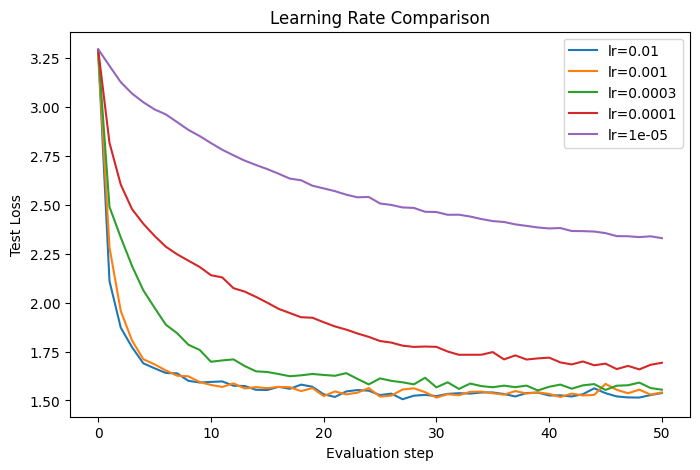

Best learning rate: 0.01


In [ ]:
def find_best_lr(lr_list, niter_long=10000, B=128, T=32, B_test=1024, T_test=32):
  """
  find best learning rate by comparing full test loss curves,
  returns best LR and test loss history for all LRs
  """
  lr_results = {}
  metrics_list = []

  for lr in lr_list:
    print(f"\n=== Testing learning rate {lr} ===")
    metrics = run_experiment(
            learning_rate=lr,
            niter=niter_long,
            B=B,
            T=T,
            B_test=B_test,
            T_test=T_test,
            model_overrides={
                "n_layers": 2,
                "d_model": 64,
                "n_heads": 4,
                "mlp_ratio": 4,
                "emb_dropout": 0.1,
                "attn_dropout": 0.1,
                "mlp_dropout": 0.1,
            },
    )
    lr_results[lr] = metrics["test_loss_history"]
    metrics_list.append({
        "lr": lr,
        "best_test_loss": metrics["best_test_loss"],
        "final_test_loss": metrics["final_test_loss"],
        "total_time": metrics["total_time"]
    })
    print(f"LR={lr}: Total time = {metrics['total_time']:.1f} seconds, Best test loss = {metrics['best_test_loss']:.4f}")


  # plot loss curves
  plt.figure(figsize=(8,5))
  for lr, loss_hist in lr_results.items():
    plt.plot(loss_hist, label=f"lr={lr}")
  plt.xlabel("Evaluation step")
  plt.ylabel("Test Loss")
  plt.title("Learning Rate Comparison")
  plt.legend()
  plt.show()

    # choose LR with lowest final plateau loss
  best_lr = min(metrics_list, key=lambda x: x["best_test_loss"])["lr"]
  print("Best learning rate:", best_lr)

  return best_lr, lr_results

lr_list = [1e-2, 1e-3, 3e-4, 1e-4, 1e-5]
best_lr, lr_curves = find_best_lr(lr_list, niter_long=10000)


## Find optimal number of iterations `niter` with best LR:


=== Testing niter=1000 ===
Initialized optimizer: Adam lr=0.01
niter=1000: Total time = 12.6s, Best test loss = 1.6332, Final test loss = 1.6332

=== Testing niter=2000 ===
Initialized optimizer: Adam lr=0.01
niter=2000: Total time = 16.9s, Best test loss = 1.5749, Final test loss = 1.6161

=== Testing niter=4000 ===
Initialized optimizer: Adam lr=0.01
niter=4000: Total time = 26.4s, Best test loss = 1.5365, Final test loss = 1.5532

=== Testing niter=8000 ===
Initialized optimizer: Adam lr=0.01
niter=8000: Total time = 43.3s, Best test loss = 1.4915, Final test loss = 1.5090

=== Testing niter=10000 ===
Initialized optimizer: Adam lr=0.01
niter=10000: Total time = 52.5s, Best test loss = 1.5018, Final test loss = 1.5274
Best number of iterations: 8000


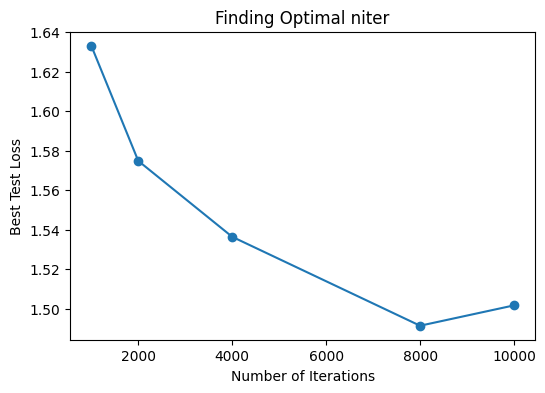

In [ ]:
niter_values=[1000, 2000, 4000, 8000, 10000]
df_niter = []

for niter in niter_values:
  print(f"\n=== Testing niter={niter} ===")
  metrics = run_experiment(
      learning_rate=best_lr,
      niter=niter,
      B=128,
      T=32
  )
  df_niter.append({"niter": niter,
                   "best_test_loss": metrics["best_test_loss"],
                   "final_test_loss": metrics["final_test_loss"],
                   "total_time": metrics["total_time"]
                   })

  print(f"niter={niter}: Total time = {metrics['total_time']:.1f}s, "
        f"Best test loss = {metrics['best_test_loss']:.4f}, "
        f"Final test loss = {metrics['final_test_loss']:.4f}")

df_niter = pd.DataFrame(df_niter)
best_niter = df_niter.loc[df_niter["best_test_loss"].idxmin(), "niter"]
print("Best number of iterations:", best_niter)

plt.figure(figsize=(6,4))
plt.plot(df_niter["niter"], df_niter["best_test_loss"], 'o-')
plt.xlabel("Number of Iterations")
plt.ylabel("Best Test Loss")
plt.title("Finding Optimal niter")
plt.show()

## Sweep batch size & sequence length

Initialized optimizer: Adam lr=0.01
B=64, T=32: Total time = 35.0s, Best test loss = 1.5384, Final test loss = 1.5761
Initialized optimizer: Adam lr=0.01
B=128, T=32: Total time = 43.4s, Best test loss = 1.5118, Final test loss = 1.5145
Initialized optimizer: Adam lr=0.01
B=128, T=64: Total time = 65.6s, Best test loss = 1.4972, Final test loss = 1.5544
Best batch size & sequence length: 128 64


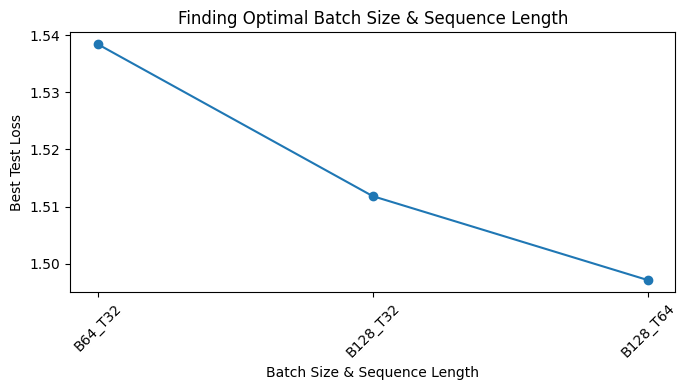

In [ ]:
batch_seq_values = [{"B":64, "T":32}, {"B":128, "T":32}, {"B":128, "T":64}]
results_bs = []

for v in batch_seq_values:
  metrics = run_experiment(
      learning_rate=best_lr,
      niter=best_niter,
      B=v["B"],
      T=v["T"]
  )
  results_bs.append({**v, **metrics})

  print(f"B={v['B']}, T={v['T']}: Total time = {metrics['total_time']:.1f}s, "
        f"Best test loss = {metrics['best_test_loss']:.4f}, "
        f"Final test loss = {metrics['final_test_loss']:.4f}")

df_bs = pd.DataFrame(results_bs)
best_bs = df_bs.loc[df_bs["best_test_loss"].idxmin()]
B_best, T_best = int(best_bs["B"]), int(best_bs["T"])
print("Best batch size & sequence length:", B_best, T_best)

plt.figure(figsize=(7,4))

labels = [f"B{row['B']}_T{row['T']}" for _, row in df_bs.iterrows()]

plt.plot(labels, df_bs["best_test_loss"], 'o-')
plt.xlabel("Batch Size & Sequence Length")
plt.ylabel("Best Test Loss")
plt.title("Finding Optimal Batch Size & Sequence Length")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Sweep architecture hyperparameters

In [ ]:
def sweep_arch(param_name, values, fixed_config):
  results = []
  for val in values:
    config = fixed_config.copy()
    config[param_name] = val
    metrics = run_experiment(
        learning_rate=best_lr,
        niter=best_niter,
        B=B_best,
        T=T_best,
        model_overrides=config
    )
    results.append({"value": val, "best_test_loss": metrics["best_test_loss"]})

    print(f"{param_name}={val}: Total time = {metrics['total_time']:.1f}s, "
          f"Best test loss = {metrics['best_test_loss']:.4f}, "
          f"Final test loss = {metrics['final_test_loss']:.4f}")

  df = pd.DataFrame(results)
  best_val = df.loc[df["best_test_loss"].idxmin(), "value"]
  return best_val, df

In [ ]:
def plot_sweep(df, param_name):
    plt.figure(figsize=(6,4))
    plt.plot(df["value"], df["best_test_loss"], 'o-')
    plt.xlabel(param_name)
    plt.ylabel("Best Test Loss")
    plt.title(f"Finding Optimal {param_name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
arch_params = {
    "n_layers": [2, 4, 6],
    "d_model": [32, 64, 128],
    "n_heads": [2, 4, 8],
    "mlp_ratio": [2, 4, 8]
}
arch_config = {}

Initialized optimizer: Adam lr=0.01
n_layers=2: Total time = 65.8s, Best test loss = 1.5111, Final test loss = 1.5326
Initialized optimizer: Adam lr=0.01
n_layers=4: Total time = 114.3s, Best test loss = 1.5105, Final test loss = 1.5981
Initialized optimizer: Adam lr=0.01
n_layers=6: Total time = 166.4s, Best test loss = 1.5206, Final test loss = 1.6358


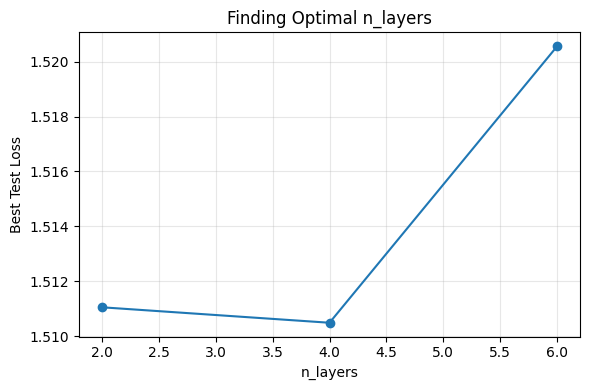

In [ ]:
best_nlayers, df_nlayers = sweep_arch("n_layers", arch_params["n_layers"], arch_config)
arch_config["n_layers"] = best_nlayers
plot_sweep(df_nlayers, "n_layers")

Initialized optimizer: Adam lr=0.01
d_model=32: Total time = 83.7s, Best test loss = 1.5414, Final test loss = 1.5690
Initialized optimizer: Adam lr=0.01
d_model=64: Total time = 113.5s, Best test loss = 1.4911, Final test loss = 1.5690
Initialized optimizer: Adam lr=0.01
d_model=128: Total time = 204.9s, Best test loss = 2.3876, Final test loss = 2.4630


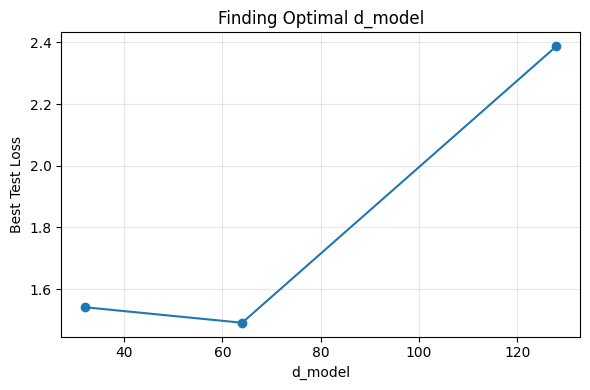

In [ ]:
best_dmodel, df_dmodel = sweep_arch("d_model", arch_params["d_model"], arch_config)
arch_config["d_model"] = best_dmodel
plot_sweep(df_dmodel, "d_model")

Initialized optimizer: Adam lr=0.01
n_heads=2: Total time = 102.0s, Best test loss = 1.4973, Final test loss = 1.5253
Initialized optimizer: Adam lr=0.01
n_heads=4: Total time = 113.4s, Best test loss = 1.5091, Final test loss = 1.5611
Initialized optimizer: Adam lr=0.01
n_heads=8: Total time = 133.4s, Best test loss = 1.4935, Final test loss = 1.6276


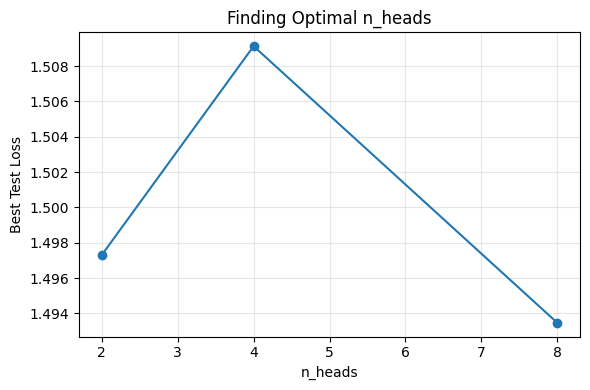

In [ ]:
best_nheads, df_nheads = sweep_arch("n_heads", arch_params["n_heads"], arch_config)
arch_config["n_heads"] = best_nheads
plot_sweep(df_nheads, "n_heads")

Initialized optimizer: Adam lr=0.01
mlp_ratio=2: Total time = 120.5s, Best test loss = 1.5092, Final test loss = 1.5735
Initialized optimizer: Adam lr=0.01
mlp_ratio=4: Total time = 132.3s, Best test loss = 1.5055, Final test loss = 1.6301
Initialized optimizer: Adam lr=0.01
mlp_ratio=8: Total time = 154.1s, Best test loss = 1.5156, Final test loss = 1.7512


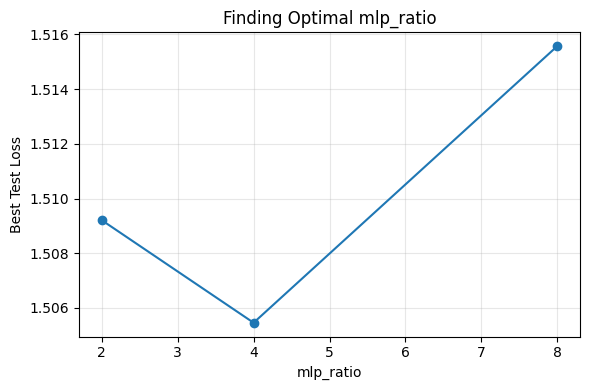

In [ ]:
best_mlp_ratio, df_mlp = sweep_arch("mlp_ratio", arch_params["mlp_ratio"], arch_config)
arch_config["mlp_ratio"] = best_mlp_ratio
plot_sweep(df_mlp, "mlp_ratio")

In [ ]:
best_lr

0.01

In [ ]:
best_niter

np.int64(8000)

In [ ]:
B_best, T_best

(128, 64)

In [ ]:
arch_config

{'n_layers': np.int64(4),
 'd_model': np.int64(64),
 'n_heads': np.int64(8),
 'mlp_ratio': np.int64(4)}

## Sweep dropout

In [ ]:
dropout_values = [0.0, 0.1, 0.2]
results_dropout = []
for val in dropout_values:
  config = arch_config.copy()
  config.update({"emb_dropout": val, "attn_dropout": val, "mlp_dropout": val})
  metrics = run_experiment(
      learning_rate=best_lr,
      niter=best_niter,
      B=B_best,
      T=T_best,
      model_overrides=config
  )
  results_dropout.append({"dropout":val, "best_test_loss": metrics["best_test_loss"]})

  print(f"dropout={val}: Total time = {metrics['total_time']:.1f}s, "
          f"Best test loss = {metrics['best_test_loss']:.4f}, "
          f"Final test loss = {metrics['final_test_loss']:.4f}")

df_dropout = pd.DataFrame(results_dropout)
best_dropout = df_dropout.loc[df_dropout["best_test_loss"].idxmin(), "dropout"]
arch_config.update({"emb_dropout": best_dropout, "attn_dropout": best_dropout, "mlp_dropout": best_dropout})
print("Best dropout:", best_dropout)

Initialized optimizer: Adam lr=0.01
dropout=0.0: Total time = 135.3s, Best test loss = 1.4994, Final test loss = 1.5850
Initialized optimizer: Adam lr=0.01
dropout=0.1: Total time = 132.3s, Best test loss = 1.4874, Final test loss = 1.6204
Initialized optimizer: Adam lr=0.01
dropout=0.2: Total time = 132.1s, Best test loss = 1.4828, Final test loss = 1.5876
Best dropout: 0.2


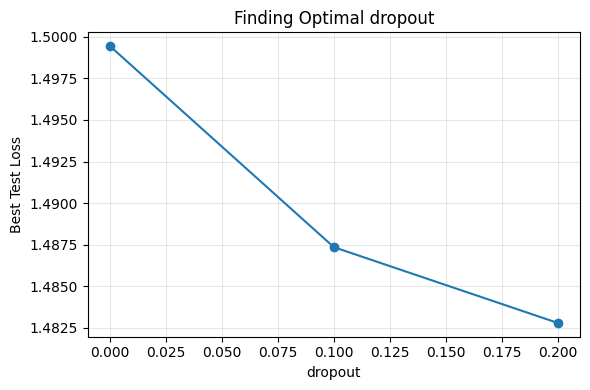

In [ ]:
plot_sweep(df_dropout.rename(columns={"dropout": "value"}), "dropout")

## `max_len`

Initialized optimizer: Adam lr=0.01
max_len=64: Total time = 133.5s, Best test loss = 1.5229, Final test loss = 1.6428
Initialized optimizer: Adam lr=0.01
max_len=128: Total time = 132.5s, Best test loss = 1.5073, Final test loss = 1.6207
Initialized optimizer: Adam lr=0.01
max_len=192: Total time = 132.9s, Best test loss = 1.5236, Final test loss = 1.5765
Best max_len: 128


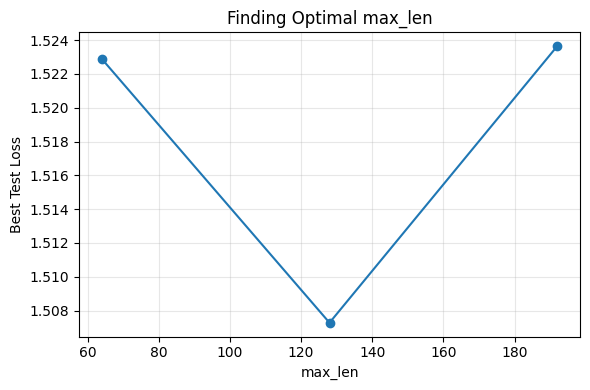

In [ ]:
max_len_values = [64, 128, 192]
results_maxlen = []

for val in max_len_values:
    config = arch_config.copy()
    metrics = run_experiment(
        learning_rate=best_lr,
        niter=best_niter,
        B=B_best,
        T=T_best,
        model_overrides={**config, "max_len": val}
    )
    results_maxlen.append({"max_len": val, "best_test_loss": metrics["best_test_loss"]})

    print(f"max_len={val}: Total time = {metrics['total_time']:.1f}s, "
          f"Best test loss = {metrics['best_test_loss']:.4f}, "
          f"Final test loss = {metrics['final_test_loss']:.4f}")

df_maxlen = pd.DataFrame(results_maxlen)
best_max_len = df_maxlen.loc[df_maxlen["best_test_loss"].idxmin(), "max_len"]
arch_config["max_len"] = int(best_max_len)
print("Best max_len:", best_max_len)

plt.figure(figsize=(6,4))
plt.plot(df_maxlen["max_len"], df_maxlen["best_test_loss"], 'o-')
plt.xlabel("max_len")
plt.ylabel("Best Test Loss")
plt.title("Finding Optimal max_len")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Save variables so they can be used again

In [ ]:
### Save variables to use it again ###

import pickle
from google.colab import drive

drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/hyperparam_results.pkl"

with open(save_path, "wb") as f:
    pickle.dump({
        "best_lr": best_lr,
        "best_niter": best_niter,
        "B_best": B_best,
        "T_best": T_best,
        "arch_config": arch_config
    }, f)

print(f"Variables saved to {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Variables saved to /content/drive/MyDrive/hyperparam_results.pkl


In [ ]:
### Reload variables to use again ###
import pickle
from google.colab import drive

drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/hyperparam_results.pkl"

with open(save_path, "rb") as f:
    data = pickle.load(f)

best_lr = data["best_lr"]
print(f"Best LR:", best_lr)
best_niter = data["best_niter"]
print(f"Best niter:", best_niter)
B_best = data["B_best"]
print(f"B_best:", B_best)
T_best = data["T_best"]
print(f"T_best:", T_best)
arch_config = data["arch_config"]
print(f"arch_config:", arch_config)

print("Variables loaded successfully")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Best LR: 0.01
Best niter: 8000
B_best: 128
T_best: 64
arch_config: {'n_layers': np.int64(4), 'd_model': np.int64(64), 'n_heads': np.int64(8), 'mlp_ratio': np.int64(4), 'emb_dropout': np.float64(0.2), 'attn_dropout': np.float64(0.2), 'mlp_dropout': np.float64(0.2), 'max_len': 128}
Variables loaded successfully
